In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/Users/zongseung/Heat-Demand/CHP-project/whole-CHP-plant-data.csv')

## 추가해야 할 변수 생성 
- CDH
- HDH
- Calendar Base dummy variables

In [7]:
# 날짜 및 불필요 변수 제거
from workalendar.asia import SouthKorea

######################################
# 아래 부분은 처음 시작했을때 주석풀고 실행해야 함.

df["date"] = pd.to_datetime(df["date"])
df.drop(["Unnamed: 0", "year", "month", "day", "ymd"], axis=1, inplace=True) # 
df.set_index("date", inplace=True)
########################################
df.sort_index(inplace=True)
# 이후 

df1 = df.copy()
cal = SouthKorea()

df1["is_weekend"] = (df1.index.dayofweek >= 5).astype(int)

dates = df1.index.normalize() # 시간 단위가 아닌 날짜만 남기기
unique_dates = pd.Index(dates.unique())

holiday_map = {d: int(cal.is_holiday(d.date())) for d in unique_dates}

# 매핑 처리
df1["is_holiday"] = dates.map(holiday_map).astype(int)

# 평일만 처리하는 경우
df1["is_offday"] = ((df1["is_weekend"] == 1) | (df1["is_holiday"] == 1)).astype(int)

T_base = 18.0
df1["hdh"] = np.maximum(0.0, T_base - df1["temperature_imp"].astype(float))
df1["cdh"] = np.maximum(0.0, df1["temperature_imp"].astype(float) - T_base)


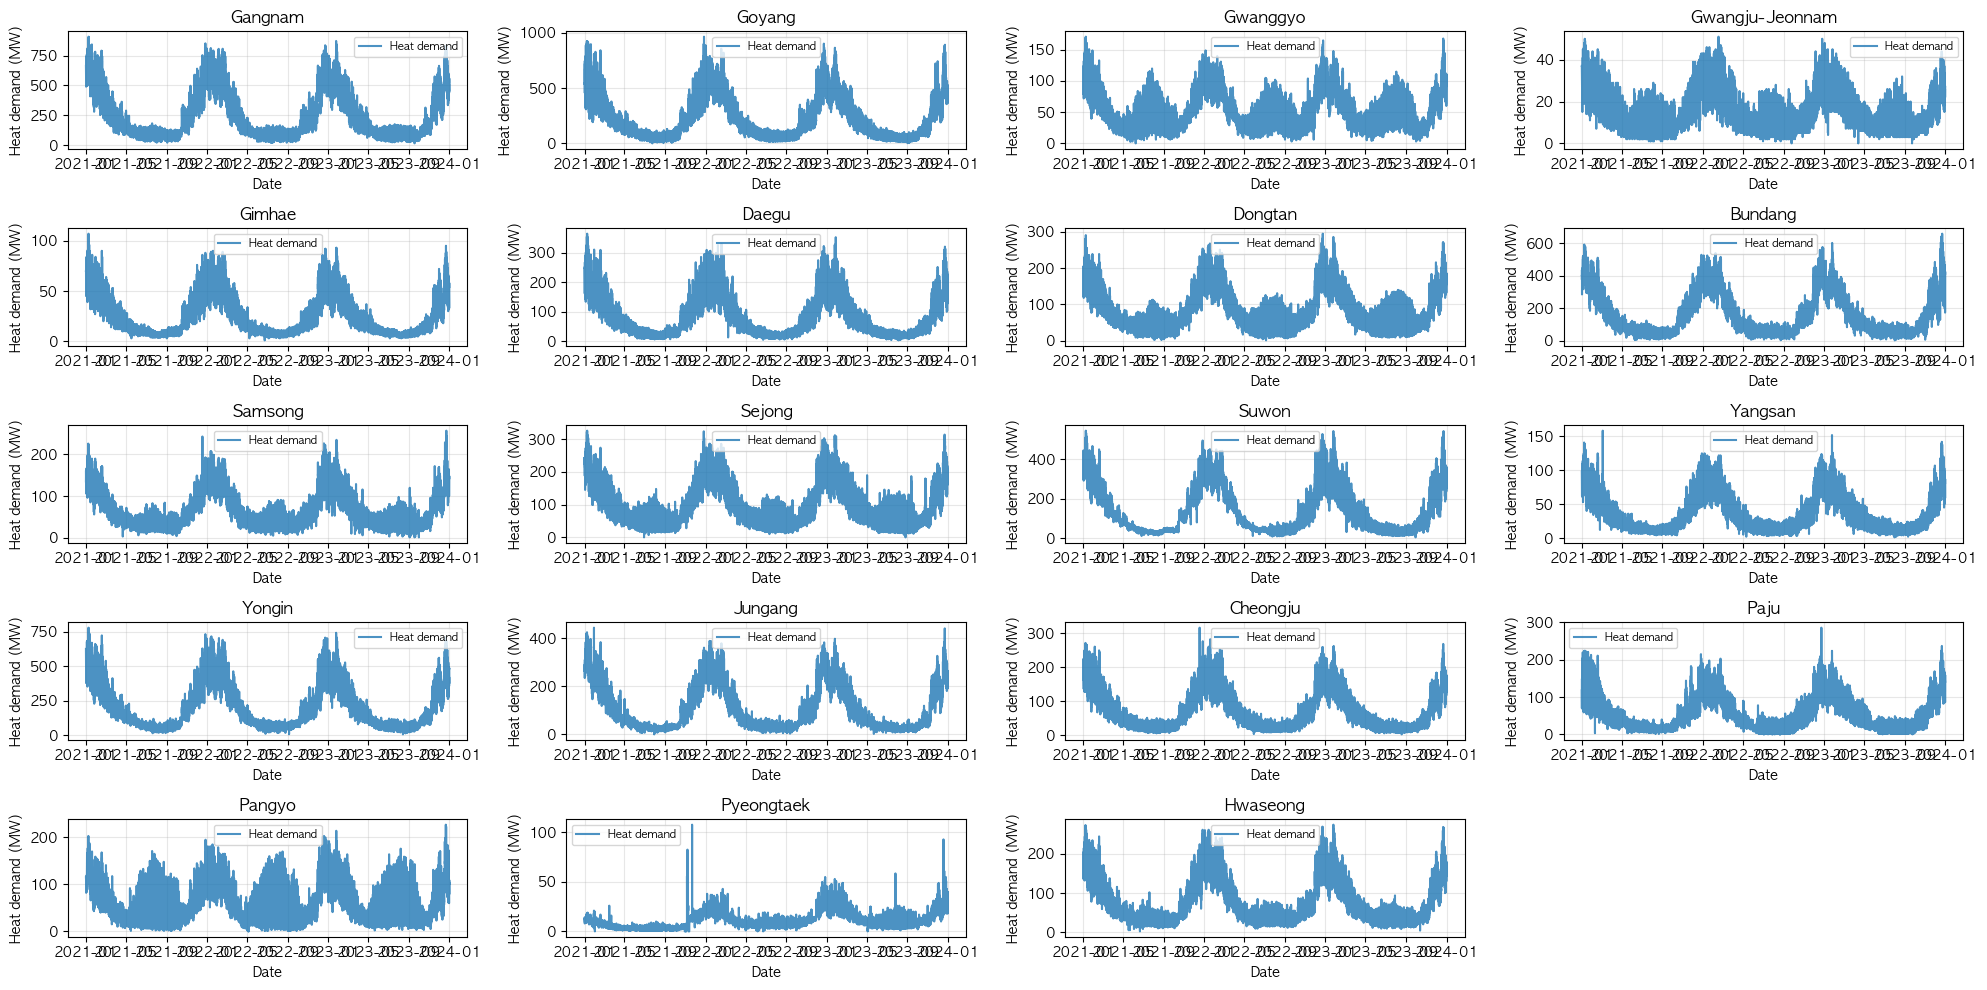

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# 폰트(영어만 쓰면 사실 필요 없지만, 그대로 둬도 무방)
mpl.rcParams["font.family"] = "AppleGothic"
mpl.rcParams["axes.unicode_minus"] = False

# 한글 → 영어 매핑
BRANCH_EN = {
    "강남": "Gangnam",
    "고양": "Goyang",
    "광교": "Gwanggyo",
    "광주전남": "Gwangju-Jeonnam",
    "김해": "Gimhae",
    "대구": "Daegu",
    "동탄": "Dongtan",
    "분당": "Bundang",
    "삼송": "Samsong",
    "세종": "Sejong",
    "수원": "Suwon",
    "양산": "Yangsan",
    "용인": "Yongin",
    "중앙": "Jungang",
    "청주": "Cheongju",
    "파주": "Paju",
    "판교": "Pangyo",
    "평택": "Pyeongtaek",
    "화성": "Hwaseong",
}

# 19개 지사 그래프 생성
nrows, ncols = 5, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))
axs = axs.flatten()

plants = np.unique(df1["branch"])

for i in range(nrows * ncols):
    ax = axs[i]
    if i < len(plants):
        plant_name_kr = plants[i]
        plant_name_en = BRANCH_EN.get(plant_name_kr, str(plant_name_kr))  # 매핑 없으면 원문 사용

        plant_data = df1[df1["branch"] == plant_name_kr].sort_index()

        ax.plot(plant_data.index, plant_data["heat_demand_imp"], label="Heat demand", alpha=0.8)

        ax.set_title(plant_name_en)   # <-- 영어 제목
        ax.set_xlabel("Date")
        ax.set_ylabel("Heat demand (MW)")  # 지금 값이 수요면 Degree Hours가 아니라 MW가 맞음
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


## Part 별 분리 실시
- A : 일반적인 패턴 (대표발전소 : 강남)
- B : 여름 피크 치는 패턴 (대표발전소 : 화성)
- 이렇게 두개 타겟잡아서 처리한다.

In [9]:
df1.reset_index(inplace=True)

In [10]:
def summer_winter_ratio(
    df,
    date_col="date",          # datetime 컬럼
    branch_col="branch",      # 지점 컬럼
    y_col="heat_demand_imp",  # 수요 컬럼
    summer_months=(6, 7, 8),
    winter_months=(12, 1, 2),
    agg="mean",               # "mean" 또는 "median" (mean 권장)
    min_obs=24*20             # 최소 관측치(예: 20일치) 미만이면 NaN 처리
):
    d = df[[date_col, branch_col, y_col]].copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # 월 추출
    d["month"] = d[date_col].dt.month

    # 그룹별 여름/겨울 집계
    def _agg(x):
        return x.mean() if agg == "mean" else x.median()

    summer = (
        d[d["month"].isin(summer_months)]
        .groupby(branch_col)[y_col]
        .agg(["count", _agg])
        .rename(columns={"count": "n_summer", "<lambda>": "summer"})
    )
    # pandas 버전에 따라 컬럼명이 달라질 수 있어서 안전하게 재정의
    summer.columns = ["n_summer", "summer"]

    winter = (
        d[d["month"].isin(winter_months)]
        .groupby(branch_col)[y_col]
        .agg(["count", _agg])
        .rename(columns={"count": "n_winter", "<lambda>": "winter"})
    )
    winter.columns = ["n_winter", "winter"]

    out = summer.join(winter, how="outer")
    out["SWR"] = out["summer"] / out["winter"]

    # 관측치 부족한 지점은 NaN 처리
    out.loc[(out["n_summer"] < min_obs) | (out["n_winter"] < min_obs), ["summer", "winter", "SWR"]] = np.nan

    return out.sort_values("SWR", ascending=False)


# train_heat_ta_interp	heat_demand_imp	temperature_imp	
swr = summer_winter_ratio(
    df1,
    date_col="date",
    branch_col="branch",
    y_col="heat_demand_imp",   # 또는 원본/다른 컬럼명
    agg="mean",
    min_obs=24*20
)

print(swr)

# 결과 확인결과 섹션은 다음고 같이 나눈다 - 평택은 그냥 제거 : 데이터형태가 이상함. 지표 확인결과 SWR ≥ 0.25 인데  Summer Baseload Ratio
# 여름에 피크치는 부분 : 판교, 광교, 광주전남, 동탄, 삼송, 세종 
# 일반적인 부분 : 나머지 다 

        n_summer     summer  n_winter      winter       SWR
branch                                                     
판교          6624  55.134377      6479  100.536966  0.548399
광교          6624  48.690821      6479   89.006174  0.547050
광주전남        6624   9.841938      6479   27.749035  0.354677
평택          6624   7.160720      6479   20.314555  0.352492
동탄          6624  55.229167      6479  160.618768  0.343853
삼송          6624  42.456975      6479  127.573391  0.332804
세종          6624  55.860054      6479  191.642537  0.291480
화성          6624  36.647494      6479  158.663065  0.230977
양산          6624  13.510870      6479   75.826208  0.178182
강남          6624  90.656552      6479  528.334774  0.171589
파주          6624  19.545743      6479  116.402068  0.167916
청주          6624  24.620530      6479  153.993518  0.159880
김해          6624   8.134511      6479   52.758605  0.154184
용인          6624  66.567784      6479  437.053712  0.152310
분당          6624  51.738283      6479  3

In [11]:
df1

date branch  train_heat_ta_interp  heat_demand_imp  \
0      2021-01-01 01:00:00     강남                  -7.2            663.0   
1      2021-01-01 01:00:00     광교                  -8.1             98.0   
2      2021-01-01 01:00:00     고양                  -8.7            739.0   
3      2021-01-01 01:00:00     판교                  -7.0            115.0   
4      2021-01-01 01:00:00   광주전남                  -3.9             37.0   
...                    ...    ...                   ...              ...   
499296 2023-12-31 23:00:00     수원                  -1.1            348.0   
499297 2023-12-31 23:00:00     판교                  -1.6            101.0   
499298 2023-12-31 23:00:00     고양                  -1.1            473.0   
499299 2023-12-31 23:00:00     세종                   2.8            189.0   
499300 2023-12-31 23:00:00     화성                   1.6            173.0   

        temperature_imp season  is_weekend  is_holiday  is_offday   hdh  cdh  
0                  -7.2     겨울           0           1          1  25.2  0.0  
1                  -8.1     겨울           0           1          1  26.1  0.0  
2                  -8.7     겨울           0           1          1  26.7  0.0  
3                  -7.0     겨울           0           1          1  25.0  0.0  
4                  -3.9     겨울           0           1          1  21.9  0.0  
...                 ...    ...         ...         ...        ...   ...  ...  
499296             -1.1     겨울           1           0          1  19.1  0.0  
499297             -1.6     겨울           1           0          1  19.6  0.0  
499298             -1.1     겨울           1           0          1  19.1  0.0  
499299              2.8     겨울           1           0          1  15.2  0.0  
499300              1.6     겨울           1           0          1  16.4  0.0  

[499301 rows x 11 columns]

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


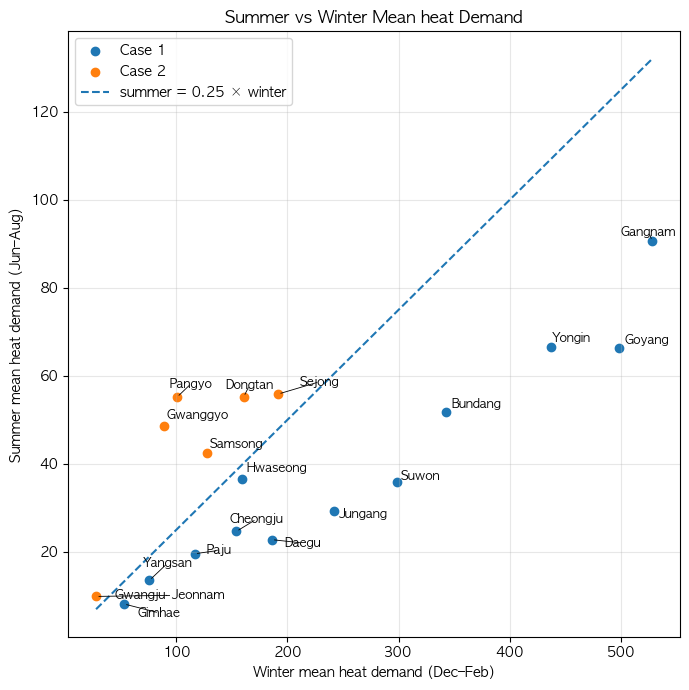

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text

# (선택) 혹시 한글이 남을 경우 대비
mpl.rcParams["font.family"] = "AppleGothic"
mpl.rcParams["axes.unicode_minus"] = False

# 한글 지점명 -> 영어 라벨 매핑 (필요시 수정/추가)
BRANCH_EN = {
    "강남": "Gangnam",
    "고양": "Goyang",
    "광교": "Gwanggyo",
    "광주전남": "Gwangju-Jeonnam",
    "김해": "Gimhae",
    "대구": "Daegu",
    "동탄": "Dongtan",
    "분당": "Bundang",
    "삼송": "Samsong",
    "세종": "Sejong",
    "수원": "Suwon",
    "양산": "Yangsan",
    "용인": "Yongin",
    "중앙": "Jungang",
    "청주": "Cheongju",
    "파주": "Paju",
    "판교": "Pangyo",
    "평택": "Pyeongtaek",
    "화성": "Hwaseong",
}

def plot_swr_from_table_adjusttext(
    swr,
    thr=0.25,
    exclude=("평택", "Pyeongtaek"),
    title="Summer vs Winter Mean heat Demand",
    figsize=(7, 7),
    savepath=None,
    label_fontsize=9,
):
    d = swr.copy()

    # index가 branch라고 가정
    if exclude:
        d = d[~d.index.isin(exclude)]

    # NaN 제거
    d = d.dropna(subset=["summer", "winter", "SWR"])
    if d.empty:
        raise ValueError(
            "No data to plot (summer/winter/SWR are all NaN). "
            "Try lowering min_obs (e.g., min_obs=0) or check date filtering."
        )

    case2 = d["SWR"] >= thr
    case1 = ~case2

    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(d.loc[case1, "winter"], d.loc[case1, "summer"], label="Case 1")
    ax.scatter(d.loc[case2, "winter"], d.loc[case2, "summer"], label="Case 2")

    # 기준선: summer = thr * winter
    x_min, x_max = d["winter"].min(), d["winter"].max()
    xs = np.linspace(x_min, x_max, 200)
    ax.plot(xs, thr * xs, linestyle="--", label=f"summer = {thr:.2f} × winter")

    # 라벨(영어) + adjustText
    texts = []
    for br, r in d.iterrows():
        label = BRANCH_EN.get(br, str(br))  # 영어 없으면 원문 fallback
        texts.append(ax.text(r["winter"], r["summer"], label, fontsize=label_fontsize))

    adjust_text(
        texts,
        ax=ax,
        # 점 위치로 당겨지는 힘(너무 크면 점에서 멀어짐)
        force_text=0.5,
        force_points=0.2,
        # 화살표 표시(겹침 제거 후 점과 라벨 연결)
        arrowprops=dict(arrowstyle="-", lw=0.6),
        # 확장 영역: 텍스트끼리/점과의 충돌 여유
        expand_text=(1.05, 1.15),
        expand_points=(1.05, 1.2),
    )

    ax.set_title(title)
    ax.set_xlabel("Winter mean heat demand (Dec–Feb)")
    ax.set_ylabel("Summer mean heat demand (Jun–Aug)")
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# 사용
plot_swr_from_table_adjusttext(swr, thr=0.25, exclude=("평택",))


## 열수요와 기온 그리고 계절에 대한 관계 그래프 생성

In [14]:
df1.set_index("date",inplace = True)

In [15]:
# 열에 있는 값들 이름 변경
seasons_map = {
    "봄": "Spring",
    "여름": "Summer",
    "가을": "Fall",
    "겨울": "Winter"}

df1["season"] = df1["season"].map(seasons_map)

In [16]:
df1

branch  train_heat_ta_interp  heat_demand_imp  \
date                                                                
2021-01-01 01:00:00     강남                  -7.2            663.0   
2021-01-01 01:00:00     광교                  -8.1             98.0   
2021-01-01 01:00:00     고양                  -8.7            739.0   
2021-01-01 01:00:00     판교                  -7.0            115.0   
2021-01-01 01:00:00   광주전남                  -3.9             37.0   
...                    ...                   ...              ...   
2023-12-31 23:00:00     수원                  -1.1            348.0   
2023-12-31 23:00:00     판교                  -1.6            101.0   
2023-12-31 23:00:00     고양                  -1.1            473.0   
2023-12-31 23:00:00     세종                   2.8            189.0   
2023-12-31 23:00:00     화성                   1.6            173.0   

                     temperature_imp  season  is_weekend  is_holiday  \
date                                                                   
2021-01-01 01:00:00             -7.2  Winter           0           1   
2021-01-01 01:00:00             -8.1  Winter           0           1   
2021-01-01 01:00:00             -8.7  Winter           0           1   
2021-01-01 01:00:00             -7.0  Winter           0           1   
2021-01-01 01:00:00             -3.9  Winter           0           1   
...                              ...     ...         ...         ...   
2023-12-31 23:00:00             -1.1  Winter           1           0   
2023-12-31 23:00:00             -1.6  Winter           1           0   
2023-12-31 23:00:00             -1.1  Winter           1           0   
2023-12-31 23:00:00              2.8  Winter           1           0   
2023-12-31 23:00:00              1.6  Winter           1           0   

                     is_offday   hdh  cdh  
date                                       
2021-01-01 01:00:00          1  25.2  0.0  
2021-01-01 01:00:00          1  26.1  0.0  
2021-01-01 01:00:00          1  26.7  0.0  
2021-01-01 01:00:00          1  25.0  0.0  
2021-01-01 01:00:00          1  21.9  0.0  
...                        ...   ...  ...  
2023-12-31 23:00:00          1  19.1  0.0  
2023-12-31 23:00:00          1  19.6  0.0  
2023-12-31 23:00:00          1  19.1  0.0  
2023-12-31 23:00:00          1  15.2  0.0  
2023-12-31 23:00:00          1  16.4  0.0  

[499301 rows x 10 columns]

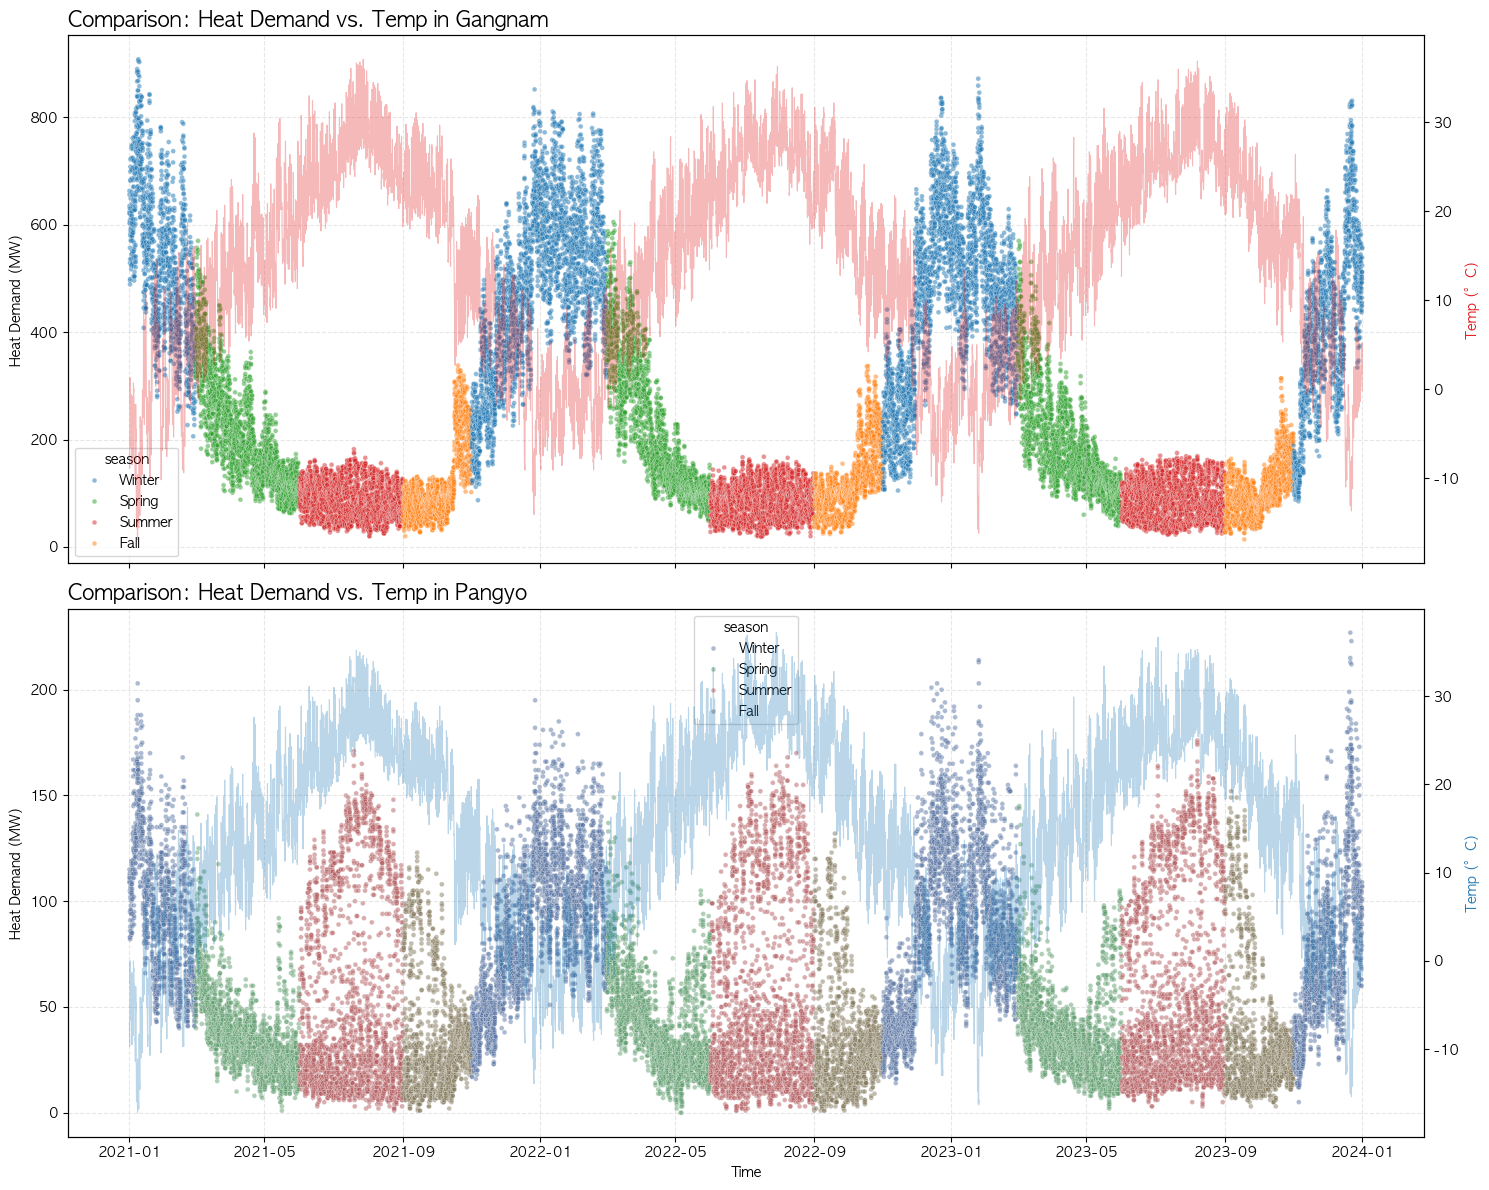

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 지점 및 데이터 준비
branch_1 = "강남"
branch_2 = "판교"
data1 = df1[df1["branch"] == branch_1]
data2 = df1[df1["branch"] == branch_2]

# 2. 지점별 서로 다른 팔레트 설정
# 상단용: 기존 선명한 색상 (Vivid)
palette1 = {"Winter": "#1f77b4", "Spring": "#2ca02c", "Summer": "#d62728", "Fall": "#ff7f0e"}
# 하단용: 조금 더 차분하거나 보라/민트 계열의 다른 색상 (Muted/Deep)
palette2 = {"Winter": "#5975a4", "Spring": "#5f9e6e", "Summer": "#b55d60", "Fall": "#857a5d"}

# 2행 1열 서브플롯 (x축 공유)
fig, (ax1_left, ax2_left) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# --- [상단: 강남] ---
ax1_right = ax1_left.twinx()
# 열수요 (palette1 사용)
sns.scatterplot(data=data1, x=data1.index, y="heat_demand_imp", hue="season", 
                palette=palette1, s=12, alpha=0.5, ax=ax1_left)
# 기온 (강한 빨간색 계열)
sns.lineplot(data=data1, x=data1.index, y="temperature_imp", 
             color="#e31a1c", linewidth=0.8, alpha=0.3, ax=ax1_right)

ax1_left.set_title(f"Comparison: Heat Demand vs. Temp in Gangnam", fontsize=15, fontweight='bold', loc='left')
ax1_left.set_ylabel("Heat Demand (MW)", fontweight='bold')
ax1_right.set_ylabel("Temp (°C)", color="#e31a1c", style='italic')
ax1_left.grid(True, linestyle='--', alpha=0.3)


# --- [하단: 분당] ---
ax2_right = ax2_left.twinx()
# 열수요 (palette2 사용 - 상단과 색이 다름)
sns.scatterplot(data=data2, x=data2.index, y="heat_demand_imp", hue="season", 
                palette=palette2, s=12, alpha=0.5, ax=ax2_left)
# 기온 (차분한 파란색/회색 계열로 차별화)
sns.lineplot(data=data2, x=data2.index, y="temperature_imp", 
             color="#1f78b4", linewidth=0.8, alpha=0.3, ax=ax2_right)

ax2_left.set_title(f"Comparison: Heat Demand vs. Temp in Pangyo", fontsize=15, fontweight='bold', loc='left')
ax2_left.set_ylabel("Heat Demand (MW)", fontweight='bold')
ax2_right.set_ylabel("Temp (°C)", color="#1f78b4", style='italic')
ax2_left.set_xlabel("Time")
ax2_left.grid(True, linestyle='--', alpha=0.3)


# 3. 마무리
plt.tight_layout()
plt.show()

## HDH vs CDH

In [18]:
np.unique(df1["branch"])

array(['강남', '고양', '광교', '광주전남', '김해', '대구', '동탄', '분당', '삼송', '세종', '수원',
       '양산', '용인', '중앙', '청주', '파주', '판교', '평택', '화성'], dtype=object)

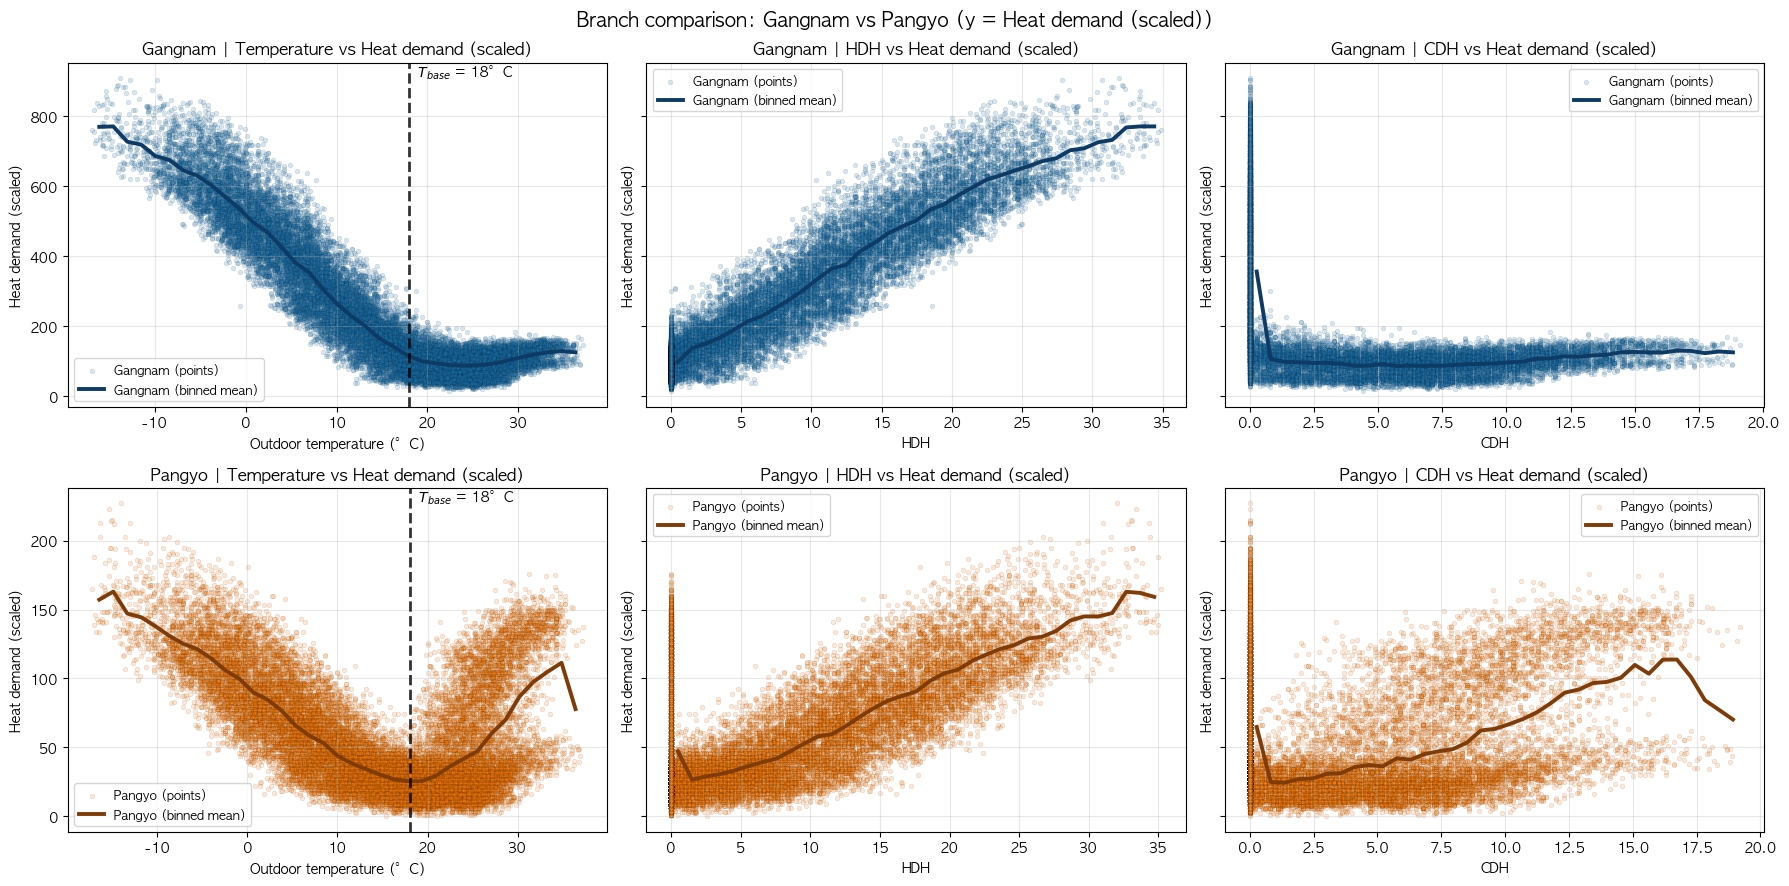

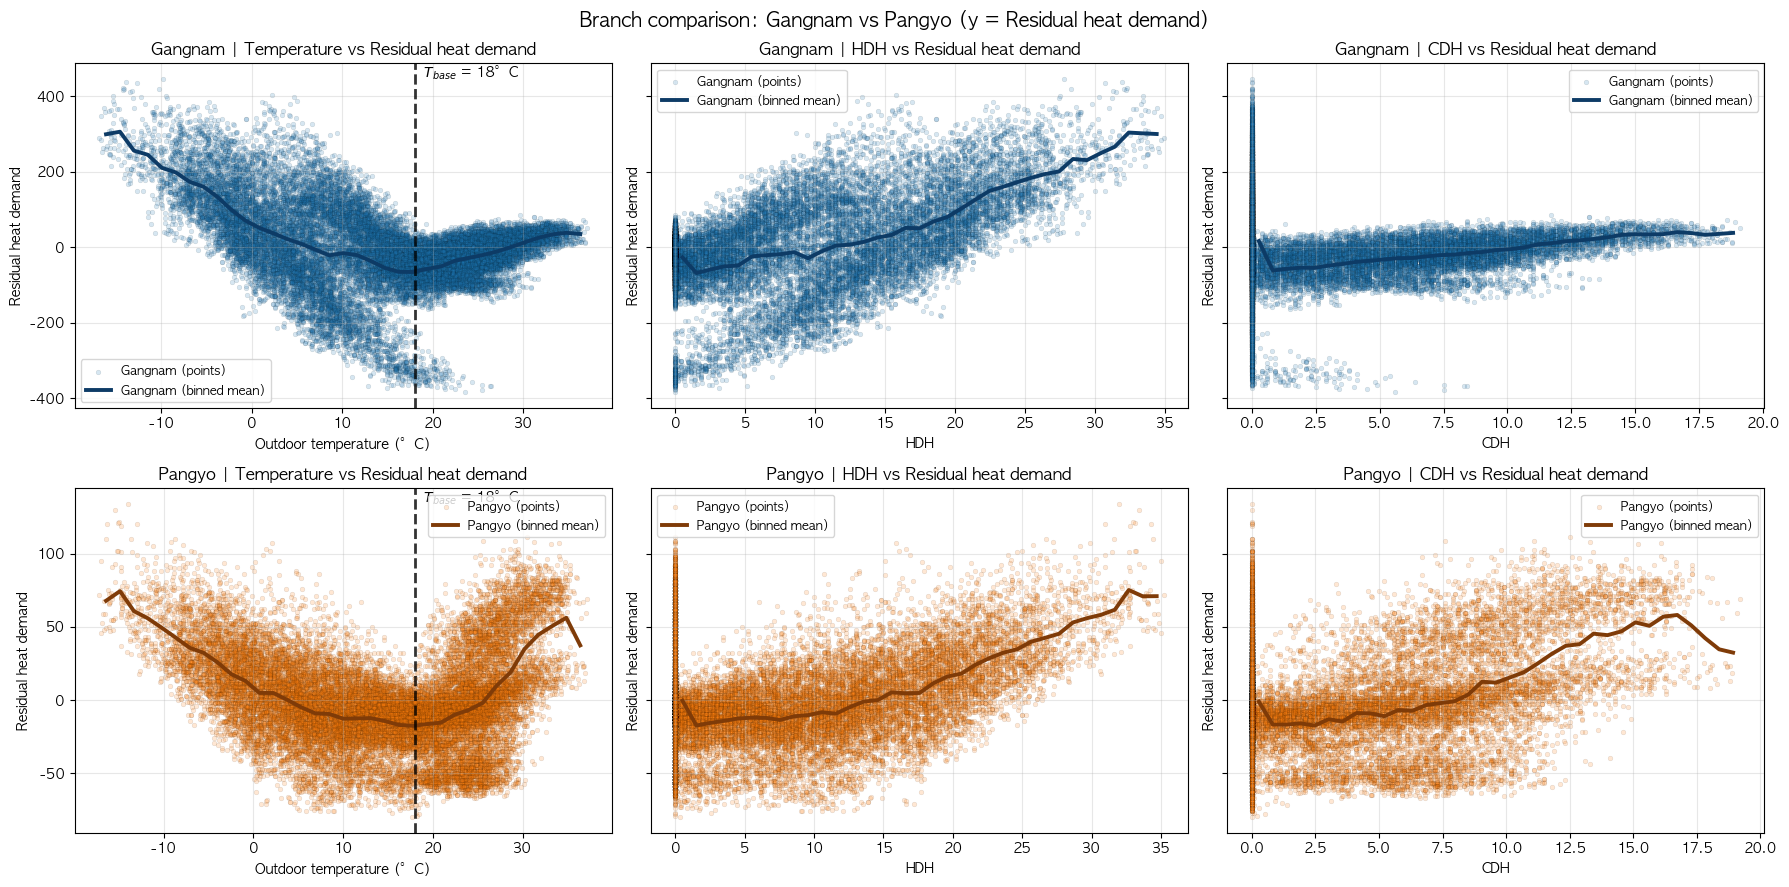

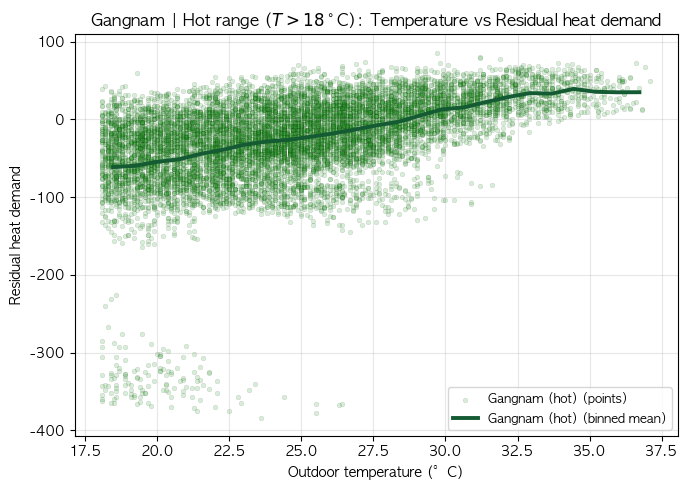

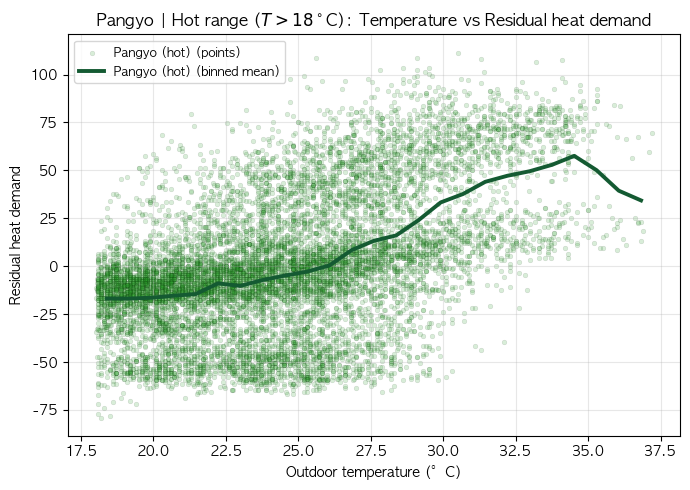

In [30]:
# 여름에 피크치는 부분 : 판교, 광교, 광주전남, 동탄, 삼송, 세종 
# 일반적인 부분 : 나머지 다 

branch_1 = "강남"
branch_2 = "판교"

branch_name_map = {
    "강남": "Gangnam",
    "판교": "Pangyo",
}

data1 = df1[df1["branch"] == branch_1].copy()
data2 = df1[df1["branch"] == branch_2].copy()

# -------------------------
# 1) Simple residual (optional)
# -------------------------
def add_simple_residual(df, y_col="heat_demand_imp",
                        group_cols=("season", "is_weekend", "is_holiday", "is_offday"),
                        out_col="y_resid"):
    gmean = df.groupby(list(group_cols))[y_col].transform("mean")
    df[out_col] = df[y_col] - gmean
    return df

data1 = add_simple_residual(data1)
data2 = add_simple_residual(data2)

# -------------------------
# 2) Scatter + binned mean utility (EN labels)
# -------------------------
def scatter_with_binned_mean(
    ax, x, y, bins=30, title="", xlabel="", ylabel="",
    vline=None, vline_label=None,
    scatter_color="tab:blue", line_color="tab:blue",
    scatter_alpha=0.18, scatter_size=12, line_width=2.8,
    label_prefix=None
):
    m = np.isfinite(x) & np.isfinite(y)
    x = np.asarray(x)[m]
    y = np.asarray(y)[m]

    # Points
    ax.scatter(
        x, y,
        s=scatter_size,
        alpha=scatter_alpha,
        c=scatter_color,
        edgecolors="black",
        linewidths=0.25,
        label=None if label_prefix is None else f"{label_prefix} (points)"
    )

    # Binned mean curve
    if len(x) > 0:
        edges = np.linspace(np.nanmin(x), np.nanmax(x), bins + 1)
        idx = np.digitize(x, edges) - 1
        centers = (edges[:-1] + edges[1:]) / 2

        y_means = np.array([
            np.nanmean(y[idx == i]) if np.any(idx == i) else np.nan
            for i in range(bins)
        ])

        ax.plot(
            centers, y_means,
            linewidth=line_width,
            color=line_color,
            label=None if label_prefix is None else f"{label_prefix} (binned mean)"
        )

    # Base temperature line
    if vline is not None:
        ax.axvline(vline, linewidth=2, linestyle="--", color="black", alpha=0.8)
        if vline_label:
            ax.text(vline, ax.get_ylim()[1], f"  {vline_label}", va="top", ha="left")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

# -------------------------
# 3) Panel plot (2 branches x 3 variables) with EN labels
# -------------------------
T_BASE = 18

def plot_branch_panels(df_a, name_a_raw, df_b, name_b_raw, y_col="heat_demand_imp", bins=35):
    name_a = branch_name_map.get(name_a_raw, name_a_raw)
    name_b = branch_name_map.get(name_b_raw, name_b_raw)

    # Colors
    a_scatter, a_line = "#1f77b4", "#0d3b66"
    b_scatter, b_line = "#ff7f0e", "#7f3b08"

    # y label mapping for paper
    y_label_map = {
        "heat_demand_imp": "Heat demand (scaled)",
        "y_resid": "Residual heat demand",
    }
    y_label = y_label_map.get(y_col, y_col)

    fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharey="row")

    # Row 1: A
    scatter_with_binned_mean(
        axes[0, 0],
        df_a["temperature_imp"].values, df_a[y_col].values,
        bins=bins,
        title=f"{name_a} | Temperature vs {y_label}",
        xlabel="Outdoor temperature (°C)",
        ylabel=y_label,
        vline=T_BASE, vline_label=f"$T_{{base}}$ = {T_BASE}°C",
        scatter_color=a_scatter, line_color=a_line,
        label_prefix=name_a
    )
    scatter_with_binned_mean(
        axes[0, 1],
        df_a["hdh"].values, df_a[y_col].values,
        bins=bins,
        title=f"{name_a} | HDH vs {y_label}",
        xlabel="HDH",
        ylabel=y_label,
        scatter_color=a_scatter, line_color=a_line,
        label_prefix=name_a
    )
    scatter_with_binned_mean(
        axes[0, 2],
        df_a["cdh"].values, df_a[y_col].values,
        bins=bins,
        title=f"{name_a} | CDH vs {y_label}",
        xlabel="CDH",
        ylabel=y_label,
        scatter_color=a_scatter, line_color=a_line,
        label_prefix=name_a
    )

    # Row 2: B
    scatter_with_binned_mean(
        axes[1, 0],
        df_b["temperature_imp"].values, df_b[y_col].values,
        bins=bins,
        title=f"{name_b} | Temperature vs {y_label}",
        xlabel="Outdoor temperature (°C)",
        ylabel=y_label,
        vline=T_BASE, vline_label=f"$T_{{base}}$ = {T_BASE}°C",
        scatter_color=b_scatter, line_color=b_line,
        label_prefix=name_b
    )
    scatter_with_binned_mean(
        axes[1, 1],
        df_b["hdh"].values, df_b[y_col].values,
        bins=bins,
        title=f"{name_b} | HDH vs {y_label}",
        xlabel="HDH",
        ylabel=y_label,
        scatter_color=b_scatter, line_color=b_line,
        label_prefix=name_b
    )
    scatter_with_binned_mean(
        axes[1, 2],
        df_b["cdh"].values, df_b[y_col].values,
        bins=bins,
        title=f"{name_b} | CDH vs {y_label}",
        xlabel="CDH",
        ylabel=y_label,
        scatter_color=b_scatter, line_color=b_line,
        label_prefix=name_b
    )

    # Legends
    for ax in axes.flat:
        ax.legend(frameon=True, fontsize=9)

    fig.suptitle(f"Branch comparison: {name_a} vs {name_b} (y = {y_label})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot A: scaled demand
plot_branch_panels(data1, branch_1, data2, branch_2, y_col="heat_demand_imp", bins=35)

# Plot B: residual demand
plot_branch_panels(data1, branch_1, data2, branch_2, y_col="y_resid", bins=35)

# -------------------------
# 4) Hot regime plot (EN)
# -------------------------
def plot_hot_regime(df, branch_raw, y_col="y_resid", bins=25,
                    scatter_color="#2ca02c", line_color="#145a32"):
    branch_en = branch_name_map.get(branch_raw, branch_raw)

    y_label_map = {
        "heat_demand_imp": "Heat demand (scaled)",
        "y_resid": "Residual heat demand",
    }
    y_label = y_label_map.get(y_col, y_col)

    hot = df[df["temperature_imp"] > T_BASE].copy()
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    scatter_with_binned_mean(
        ax,
        hot["temperature_imp"].values, hot[y_col].values,
        bins=bins,
        title=f"{branch_en} | Hot range ($T > {T_BASE}^\\circ$C): Temperature vs {y_label}",
        xlabel="Outdoor temperature (°C)",
        ylabel=y_label,
        scatter_color=scatter_color, line_color=line_color,
        label_prefix=f"{branch_en} (hot)"
    )

    ax.legend(frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

plot_hot_regime(data1, branch_1, y_col="y_resid")
plot_hot_regime(data2, branch_2, y_col="y_resid")


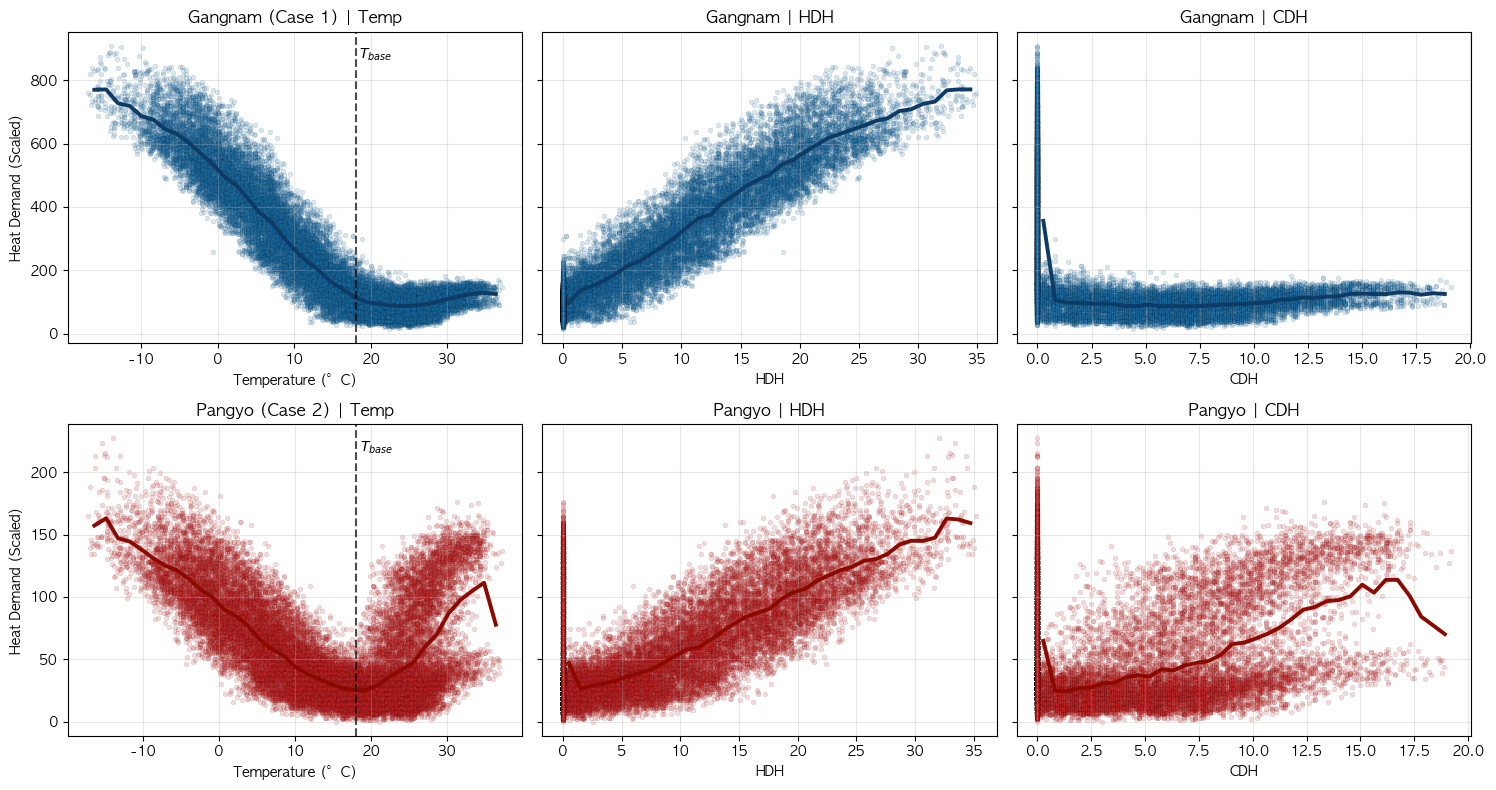

>>> Generatig Case 1 (Total 12 branches in 3x4 Grid)...
   Saved: appendix_Case1_all.png


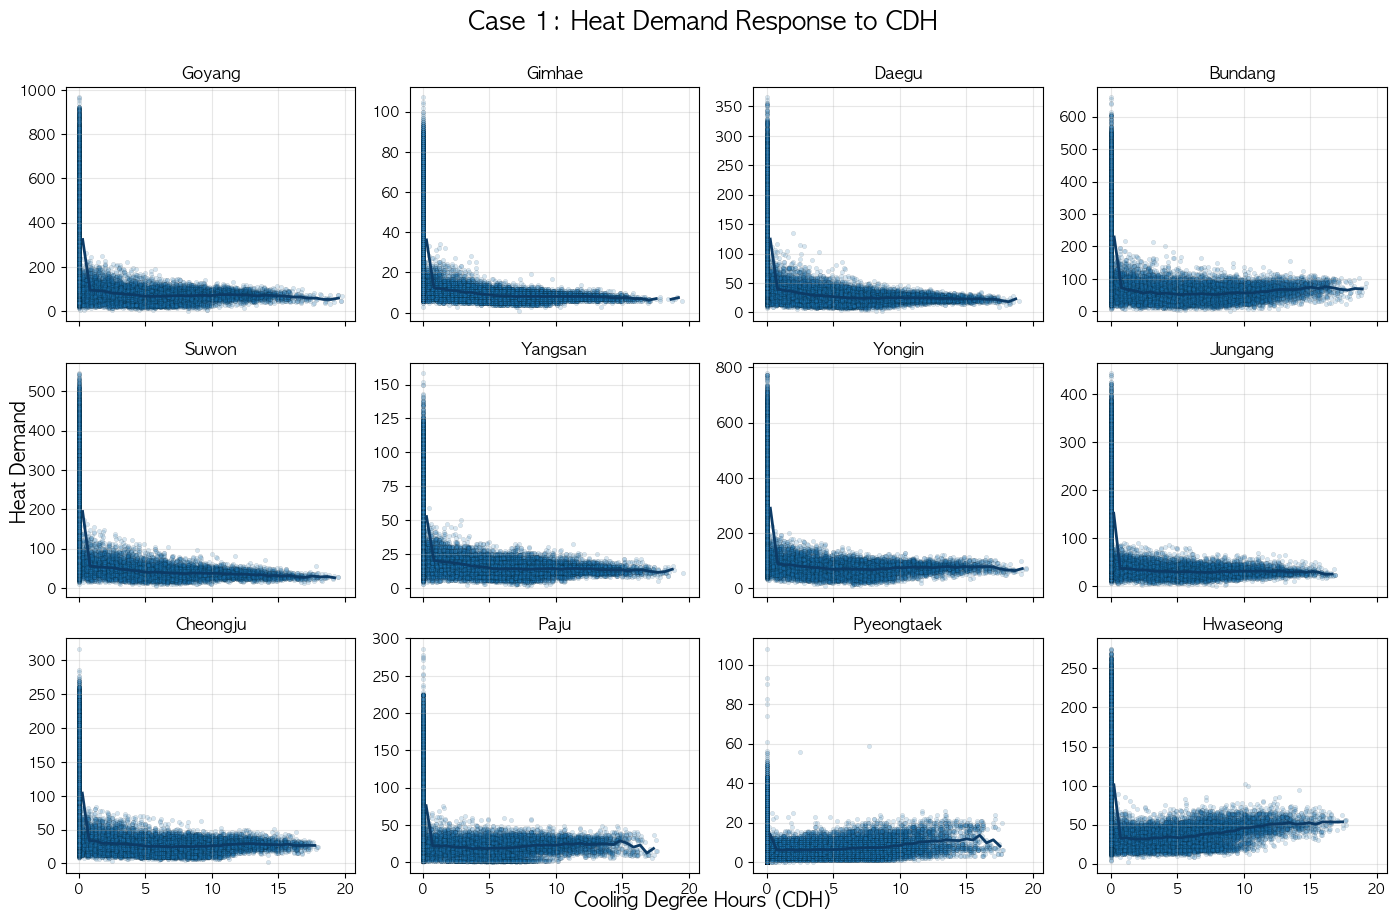

>>> Generatig Case 2 (Total 5 branches in 2x4 Grid)...
   Saved: appendix_Case2_all.png


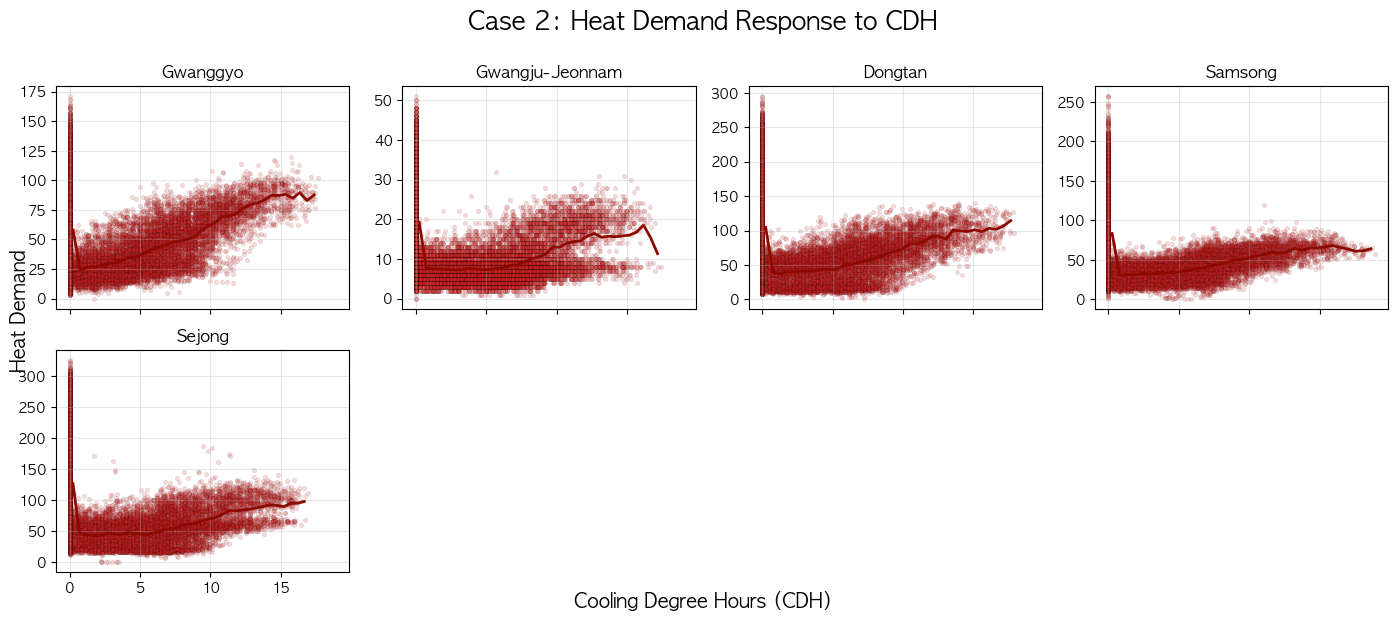

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 4. Appendix Generator (Unified Grid View)
# -------------------------
def plot_appendix_unified_grid(df, target_branches, case_label, color_scat, color_line, y_col="heat_demand_imp"):
    """
    모든 지사의 CDH 그래프를 하나의 Figure 안에 Subplot Grid로 그려냅니다.
    페이지를 나누지 않고 한 장의 이미지로 저장합니다.
    """
    n_total = len(target_branches)
    if n_total == 0:
        return

    # [레이아웃 계산]
    # 열(Col) 개수를 4개로 고정 (지사가 적으면 3개로 조정)
    if n_total <= 3:
        ncols = n_total
    else:
        ncols = 4 
    
    # 행(Row) 개수 자동 계산
    nrows = math.ceil(n_total / ncols)

    # 전체 그림 크기 설정 (지사가 많으면 세로로 길어짐)
    # 개별 슬롯 크기: 가로 3.5인치, 세로 3인치
    fig_width = 3.5 * ncols
    fig_height = 3.0 * nrows

    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), sharex=True)
    axes = axes.flatten() # 1차원 배열로 펼쳐서 인덱싱 편하게

    print(f">>> Generatig {case_label} (Total {n_total} branches in {nrows}x{ncols} Grid)...")

    for i in range(len(axes)):
        ax = axes[i]
        
        # 지사가 있는 슬롯인 경우 그리기
        if i < n_total:
            branch_raw = target_branches[i]
            sub_df = df[df["branch"] == branch_raw]
            branch_eng = branch_name_map.get(branch_raw, branch_raw)
            
            scatter_with_binned_mean(
                ax, sub_df["cdh"], sub_df[y_col],
                title=f"{branch_eng}", 
                xlabel="", ylabel="", # 축 라벨은 공간 절약을 위해 생략 (전체 제목으로 대체)
                scatter_color=color_scat, line_color=color_line,
                scatter_size=10, line_width=2.0 # 작은 그리드에 맞게 사이즈 축소
            )
            
            # X축 라벨은 맨 아래 행에만, Y축 라벨은 맨 왼쪽 열에만 (share 옵션 썼지만 명시적으로)
            # 깔끔함을 위해 개별 라벨은 생략하고 전체 title로 처리 추천
            
        else:
            # 남는 빈 슬롯은 숨김 처리
            ax.axis('off')

    # 공통 라벨
    fig.text(0.5, 0.005, 'Cooling Degree Hours (CDH)', ha='center', fontsize=14, fontweight='bold')
    fig.text(0.005, 0.5, 'Heat Demand', va='center', rotation='vertical', fontsize=14, fontweight='bold')
    
    # 전체 제목
    fig.suptitle(f"{case_label}: Heat Demand Response to CDH", fontsize=18, fontweight='bold', y=1.002)
    
    plt.tight_layout()
    
    # 파일 저장
    filename = f"appendix_{case_label.replace(' ', '')}_all.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"   Saved: {filename}")
    plt.show()
    plt.close(fig)

# -------------------------
# 실행
# -------------------------
# Main Figure (대표 2개)
plot_main_comparison(df1, rep_branch_case1, rep_branch_case2)

# Case 1 (파란색) - 한 장에 모두 출력
plot_appendix_unified_grid(
    df1, appendix_case1_list, "Case 1", 
    color_scat="#1f77b4", color_line="#0d3b66"
)

# Case 2 (붉은색) - 한 장에 모두 출력
plot_appendix_unified_grid(
    df1, appendix_case2_list, "Case 2", 
    color_scat="#d62728", color_line="#8c0900"
)

### 번외 : sector 1 vs sector 2 두두